In [1]:
# python based
import tensorflow as tf
# print("tensorflow version:",tf.__version__)
# print("tf.keras version:",tf.keras.__version__)

from pathlib import Path
import time
import shutil
import random
import os
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam, Nadam
import matplotlib.pyplot as plt

# custom 
from loss import *
from models import * # This model does not have any regulariers (uses mdmmm for that)
from OptimizedDataGenerator import OptimizedDataGenerator
import mdmm

2024-12-03 07:32:56.409063: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 07:32:56.409128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 07:32:56.410422: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 07:32:56.418390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 07:32:57.301780: W tensorflow/compiler/tf2

In [2]:
# dataset_path = '/depot/cms/users/dkondra/smart-pixels/dataset8/unflipped-positive'
dataset_path = '/depot/cms/users/das214/dataset8/unflipped'
data_directory_path = os.path.join(dataset_path, 'recon3D/')
labels_directory_path = os.path.join(dataset_path, 'labels/')

data_files_path_list = [os.path.join(data_directory_path, f) for f in os.listdir(data_directory_path)]
labels_files_path_list = [os.path.join(labels_directory_path, f) for f in os.listdir(labels_directory_path)]

data_files_path_list = np.sort(data_files_path_list)
labels_files_path_list = np.sort(labels_files_path_list)

print(data_directory_path)
print(labels_directory_path)
print(len(data_files_path_list))
print(len(labels_files_path_list))

/depot/cms/users/das214/dataset8/unflipped/recon3D/
/depot/cms/users/das214/dataset8/unflipped/labels/
160
160


In [3]:
output_directory = Path("./").resolve()

batch_size = 5000
val_batch_size = 5000
train_file_size = 142
val_file_size = 6
epochs=1000

# batch_size = 500
# val_batch_size = 500
# train_file_size = 20 # controls number of train files used -> seem to run into a problem using >=50 files maybe with memory
# val_file_size = 6 # controls number of validation files used


In [4]:
os.makedirs(output_directory, exist_ok=True)
print(output_directory)

/home/das214/MDMM


In [5]:
# create tf records directory
stamp = '%08x' % random.randrange(16**8)
stamp = 1
tfrecords_dir_train = Path(output_directory, f"tfrecords_train_{stamp}").resolve()
tfrecords_dir_validation = Path(output_directory, f"tfrecords_validation_{stamp}").resolve()

tfrecords_dir_train = "/depot/cms/users/das214/tfrecords_2t_train_d8"
tfrecords_dir_validation = "/depot/cms/users/das214/tfrecords_2t_val_d8"

# clean up tf records
# utils.safe_remove_directory(tfrecords_dir_train)
# utils.safe_remove_directory(tfrecords_dir_validation)

In [6]:
# start_time = time.time()
# validation_generator = OptimizedDataGenerator(
#     data_directory_path = data_directory_path,
#     labels_directory_path = labels_directory_path,
#     is_directory_recursive = False,
#     file_type = "parquet",
#     data_format = "3D",
#     batch_size = val_batch_size,
#     file_count = val_file_size,
#     to_standardize= True,
#     include_y_local= False,
#     labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
#     input_shape = (2,13,21), # (20,13,21),
#     transpose = (0,2,3,1),
#     shuffle = False, 
#     files_from_end=True,

#     tfrecords_dir = tfrecords_dir_validation,
#     use_time_stamps = [0, 19], #-1
#     max_workers = 2
# )

# print("--- Validation generator %s seconds ---" % (time.time() - start_time))

In [7]:
# # training generator
# start_time = time.time()
# training_generator = OptimizedDataGenerator(
#     data_directory_path = data_directory_path,
#     labels_directory_path = labels_directory_path,
#     is_directory_recursive = False,
#     file_type = "parquet",
#     data_format = "3D",
#     batch_size = batch_size,
#     file_count = train_file_size,
#     to_standardize= True,
#     include_y_local= False,
#     labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
#     input_shape = (2,13,21), # (20,13,21),
#     transpose = (0,2,3,1),
#     shuffle = False, # True 

#     tfrecords_dir = tfrecords_dir_train,
#     use_time_stamps = [0, 19], #-1
#     max_workers = 2
# )
# print("--- Training generator %s seconds ---" % (time.time() - start_time))

In [8]:
training_generator = OptimizedDataGenerator(
    load_from_tfrecords_dir = tfrecords_dir_train,#'/home/das214/dataset8_analysis/semiparametric/timeslices-2/neurips-3x3-2conv/tfrecords_train_1'
    shuffle = True,
    seed = 13,
    quantize = True
)

validation_generator = OptimizedDataGenerator(
    load_from_tfrecords_dir = tfrecords_dir_validation, #'/home/das214/dataset8_analysis/semiparametric/timeslices-2/neurips-3x3-2conv/tfrecords_validation_1'
    shuffle = True,
    seed = 13,
    quantize = True
)

In [9]:
def smooth_l0(w, alpha=100):
    return tf.reduce_mean(tf.exp(- alpha * tf.square(w)))

class EqL1Constraint(mdmm.EqConstraint):
    def __init__(self, layer, target_sparsity, scale=1.0,
                 damping=1.0, epsilon=1e-5, lr_multiplier=1.0, Temp = 1.0):
        super().__init__(layer, target_value=0.0, scale=scale, damping=damping, abs_inf=True)
        
        assert 0 <= target_sparsity <= 1, "target_sparsity must be between 0 and 1"
        self.target_sparsity = target_sparsity
        self.epsilon = epsilon
        self.lr_multiplier = lr_multiplier
        print("Modified EqL1Constraint")

        self.weights_list = []
        if isinstance(layer, list):
            for l in layer:
                self.weights_list.append(l.weights[0])
        else:
            self.weights_list.append(layer.weights[0])
            

    def fn(self, inputs):
        weights_concat = tf.concat([tf.reshape(w, [-1]) for w in self.weights_list], axis=0)
        # zero_w = tf.cast(tf.less_equal(tf.abs(weights_concat), self.epsilon), tf.float32)

        l0_term = smooth_l0(weights_concat)
        # l0_term = tf.reduce_mean(zero_w)
        l1_term = tf.reduce_mean(tf.abs(weights_concat))
        # l2_term = tf.reduce_mean(tf.square(weights_concat))

        factor = self.target_sparsity**2 - l0_term**2
        factor = tf.sign(factor) * tf.sqrt(tf.abs(factor))
        fn_value = factor *l1_term # (l1_term + self.target_sparsity)
        return fn_value*batch_size

    def compute_update_lmbda(self):
        return self.lr_multiplier


In [10]:
epsilon = 1e-3
target_sparsity = 0.99
scale = 1.0
damping = 1.0

In [11]:
input_shape = (13, 21, 2)
model = CreateModel(input_shape, n_filters=5, pool_size=3)

2024-12-03 07:33:00.465125: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 856 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 7g.40gb, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-12-03 07:33:00.628340: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [12]:
from tensorflow.keras import layers, models

# initialization should not really matter
def calculate_sparsity(model, epsilon):
    zero_count = 0
    total_count = 0
    for layer in model.layers:
        if layer.weights:
            weights = layer.get_weights()[0]
            zero_count += np.sum(np.isclose(weights, 0, atol=epsilon))
            total_count += weights.size
    return zero_count / total_count if total_count > 0 else 0

new_sparsity = calculate_sparsity(model, epsilon)
print(f"Model sparsity after initialization: {new_sparsity:.3f}")

Model sparsity after initialization: 0.005


In [13]:
constraints = []
constraints.append(
    EqL1Constraint(layer=[l for l in model.layers if l.weights],
                    target_sparsity=target_sparsity, epsilon=epsilon,
                   scale = scale, damping = damping
                  )
)

mdmm_model = mdmm.MDMM(model, constraints)
mdmm_model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3),
    loss=custom_loss
)

mdmm_model.summary()

Modified EqL1Constraint
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 21, 2)]       0         
                                                                 
 q_separable_conv2d (QSepar  (None, 11, 19, 5)         33        
 ableConv2D)                                                     
                                                                 
 q_activation (QActivation)  (None, 11, 19, 5)         0         
                                                                 
 q_conv2d (QConv2D)          (None, 11, 19, 5)         30        
                                                                 
 q_activation_1 (QActivatio  (None, 11, 19, 5)         0         
 n)                                                              
                                                                 
 average_pooling2d (Average  (None, 3

In [14]:
fingerprint = '%08x' % random.randrange(16**8)
os.makedirs("trained_models_mdmm", exist_ok=True)
base_dir = f'./trained_models_mdmm/model-{fingerprint}-checkpoints'
os.makedirs(base_dir, exist_ok=True)  
checkpoint_filepath = base_dir + '/weights.{epoch:02d}-t{loss:.2f}-v{val_loss:.2f}.hdf5'

In [15]:
print(fingerprint)

076ea794


In [16]:
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, Callback

early_stopping_patience = 50

class CustomModelCheckpoint(ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        checkpoints = [f for f in os.listdir(base_dir) if f.startswith('weights')]
        if len(checkpoints) > 1:
            checkpoints.sort()
            for checkpoint in checkpoints[:-1]:
                os.remove(os.path.join(base_dir, checkpoint))

es = EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)

mcp = CustomModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=False,
    save_freq='epoch',
    verbose=1
)

csv_logger = CSVLogger(f'{base_dir}/training_log.csv', append=True)

In [17]:
x_dummy, _ = training_generator.__getitem__(0)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
import tensorflow as tf

class NormsAndLossLogger(Callback):
    def __init__(self, mdmm_model, epsilon):
        super().__init__()
        self.mdmm_model = mdmm_model
        self.epsilon = epsilon
        
        self.losses = []
        self.val_losses = [] 
        self.lmbdas = []
        self.sparsity = []
        self.norms = []
        self.inf = []
        self.layers = [l for l in mdmm_model.model.layers if l.weights]

    def on_batch_end(self, batch, logs=None):
        self.losses.append(logs.get('loss_obj', 0))  # Default to 0 if key is missing
        
        current_sparsity = []
        current_norms = []

        for layer in self.layers:
            weights = layer.weights[0]
            abs_weights = tf.abs(weights)
            sparsity = tf.reduce_mean(tf.cast(tf.less_equal(abs_weights, self.epsilon), tf.float32))
            norm = tf.reduce_mean(abs_weights)
            
            current_sparsity.append(sparsity)
            current_norms.append(norm)

        self.norms.append(current_norms)
        self.sparsity.append(current_sparsity)

        current_lmbdas = []
        # current_inf = []
        for constraint in self.mdmm_model.constraints:
            # current_inf.append(constraint(x_dummy))  # x is a dummy value
            if hasattr(constraint, 'lmbda'):
                current_lmbdas.append(constraint.lmbda.numpy())

        # self.inf.append(current_inf)
        self.lmbdas.append(current_lmbdas)

    def on_epoch_end(self, epoch, logs=None):
        current_norms = self.norms[-1] if self.norms else []
        current_sparsity = self.sparsity[-1] if self.sparsity else []
        current_lmbdas = self.lmbdas[-1] if self.lmbdas else []
        # current_inf = self.inf[-1] if self.inf else []
        self.val_losses.append(logs.get('val_loss', 0))
        
        zero_count = 0
        total_count = 0
        for layer in self.mdmm_model.model.layers:
            if layer.weights:
                weights = tf.convert_to_tensor(layer.get_weights()[0])
                abs_weights = tf.abs(weights)
                zero_count += tf.reduce_sum(tf.cast(tf.less_equal(abs_weights, self.epsilon), tf.int32))
                total_count += tf.size(weights)
    
        overall_sparsity = zero_count / total_count if total_count > 0 else 0
        
        # Print layer-wise sparsities, overall sparsity, and other details
        print(f"\nEpoch {epoch + 1}:")
        print("Layer sparsities:", ", ".join([f"{s.numpy():.4f}" for s in current_sparsity]))
        print(f"Overall sparsity: {overall_sparsity.numpy():.4f}")
        print("Lambdas:", [
            l.numpy() if isinstance(l, tf.Tensor) else l for l in current_lmbdas
        ])
        print("Validation Loss:", self.val_losses[-1])
        print()


norms_and_loss_logger = NormsAndLossLogger(mdmm_model, epsilon=epsilon)


In [19]:
history = mdmm_model.fit(
                        x=training_generator,
                        validation_data=validation_generator,
                        callbacks=[es, mcp, csv_logger, norms_and_loss_logger],
                        epochs=1000,
                        shuffle=False,
                        verbose=1
                    )

Epoch 1/1000


2024-12-03 07:33:03.743630: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-12-03 07:33:06.664237: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-03 07:33:08.064696: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x55bffe4a13f0
2024-12-03 07:33:09.665015: I external/local_xla/xla/service/service.cc:168] XLA service 0x7eee632cfd10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-03 07:33:09.665075: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB MIG 7g.40gb, Compute Capability 8.0
2024-12-03 07:33:09.678938: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733207589.821266    3675 device_compiler.h:186] Compile

1416/1419 [============================>.] - ETA: 0s - loss: 1677.0103 - loss_obj: 9392.9480 - loss_eq_l1_constraint: 19701.9546
Epoch 1: saving model to ./trained_models_mdmm/model-076ea794-checkpoints/weights.01-t1514.20-v-615.07.hdf5

Epoch 1:
Layer sparsities: 0.0000, 0.3200, 0.7056, 0.6367, 0.4598
Overall sparsity: 0.6572
Lambdas: [0.62953305]
Validation Loss: -615.0706787109375

1419/1419 [==============================] - 226s 154ms/step - loss: 1514.2002 - loss_obj: 9364.3167 - loss_eq_l1_constraint: 19652.6555 - val_loss: -615.0707
Epoch 2/1000
1419/1419 [==============================] - ETA: 0s - loss: -1712.3488 - loss_obj: -2167.5601 - loss_eq_l1_constraint: 1618.5857
Epoch 2: saving model to ./trained_models_mdmm/model-076ea794-checkpoints/weights.02-t-1712.35-v-2638.19.hdf5

Epoch 2:
Layer sparsities: 0.0000, 0.2400, 0.6931, 0.7031, 0.6652
Overall sparsity: 0.6791
Lambdas: [1.3613516]
Validation Loss: -2638.192626953125

1419/1419 [==============================] - 101s 

In [20]:
print(f"Model sparsity after Training (MDMM): { calculate_sparsity(mdmm_model.model, epsilon):.3f}")

Model sparsity after Training (MDMM): 0.668


In [21]:
current_lmbdas = []
current_inf = []
for constraint in mdmm_model.constraints:
    current_inf.append(constraint(x_dummy)) # x is a dummy actually
    if hasattr(constraint, 'lmbda'):
        current_lmbdas.append(constraint.lmbda.numpy())

print("current_lmbdas:", current_lmbdas)
print("current_inf:", current_inf)

current_lmbdas: [36.287872]
current_inf: [<tf.Tensor: shape=(), dtype=float32, numpy=3192.4443>]


In [25]:
Layers_names = ['SepConv2D', 'Con2D', 'Dense_0', 'Dense_1', 'Dense_2']

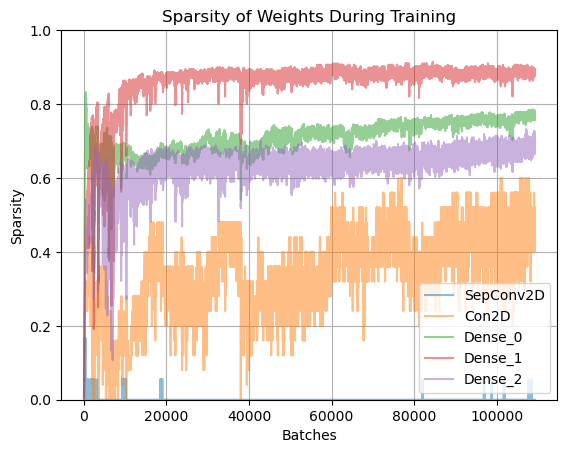

In [26]:
sparsity = np.array(norms_and_loss_logger.sparsity)  
for i in range(sparsity.shape[1]): 
    plt.plot(range(sparsity.shape[0]), sparsity[:, i], label=f'{Layers_names[i]}', alpha=0.5)
plt.title('Sparsity of Weights During Training')
plt.xlabel('Batches')
plt.ylim([0,1])
plt.ylabel('Sparsity')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
print(sparsity[-1])

[0.        0.44      0.7590278 0.890625  0.7098214]


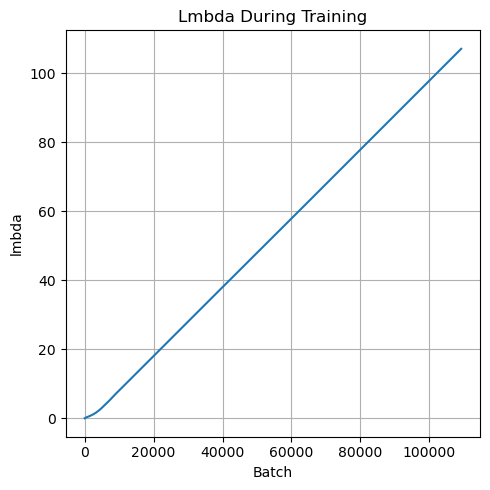

In [30]:
plt.figure(figsize=(5, 5))

lambdas = np.array(norms_and_loss_logger.lmbdas)

for i in range(lambdas.shape[1]):
    plt.plot(lambdas[:, i], label=f'Lambda{i+1}')
plt.title('Lmbda During Training')
plt.xlabel('Batch')
plt.ylabel('lmbda')
plt.grid(True)

plt.tight_layout()
plt.show()

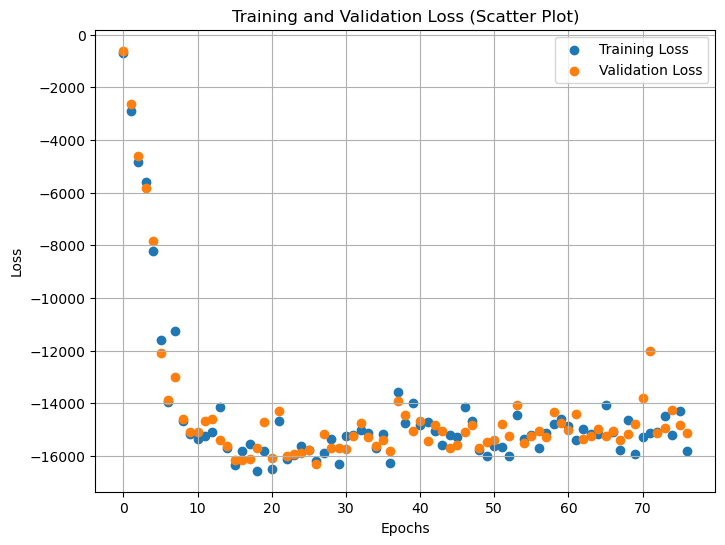

In [40]:
import matplotlib.pyplot as plt

# Extract the history
history_dict = history.history
epochs = range(len(history_dict['loss']))  # Get the epoch numbers

# Scatter plot for training and validation loss
plt.figure(figsize=(8, 6))
plt.scatter(epochs, history_dict['loss_obj'], label='Training Loss')
plt.scatter(epochs, history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Scatter Plot)')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
history_dict.keys()

dict_keys(['loss', 'loss_obj', 'loss_eq_l1_constraint', 'val_loss'])